In [1]:
from toolkit.logger import Logger
from toolkit.classes import DataFrameCreator
from toolkit.pytorch_tools import CustomImageDataLoader
from toolkit.pytorch_tools import AutoEncoder
from torchvision.transforms import Compose
from torchvision.transforms import Resize
from torchvision.transforms import Normalize
from torchvision.transforms import ToPILImage
from torchvision.transforms import ToTensor
from torchvision.transforms import RandomVerticalFlip
from torchvision.transforms import RandomRotation
from torchvision.transforms import RandomErasing

# from torchsummary import summary

from pathlib import Path

import torch

In [2]:
# torch.cuda.empty_cache()
# gc.collect()
logger = Logger("main").get_logger()

In [3]:
data = DataFrameCreator()

samples = ["./data/sd1_sample"]

In [4]:
for sample in samples:
    data.load_dataset(
        sample_dir=sample, labels={"non_defective": 0, "defective": 1}
    )
data.split_dataset()
data.info()
data["dataset"].head()

[    INFO    ] Images loaded from ./data/sd1_sample with label non_defective
[    INFO    ] Images loaded from ./data/sd1_sample with label defective
[    INFO    ] Name :          dataset
[    INFO    ] Labels:         {'non_defective': 8733}
[    INFO    ] Columns:        ('img_dir', 'img_file', 'img', 'label', 'label_enc')
[    INFO    ] Shape:          (8733, 5)
[    INFO    ] File types:     ('jpg',)
[    INFO    ] Name :          train
[    INFO    ] Labels:         {'non_defective': 6113}
[    INFO    ] Columns:        ('img_dir', 'img_file', 'img', 'label', 'label_enc')
[    INFO    ] Shape:          (6113, 5)
[    INFO    ] File types:     ('jpg',)
[    INFO    ] Name :          validation
[    INFO    ] Labels:         {'non_defective': 1746}
[    INFO    ] Columns:        ('img_dir', 'img_file', 'img', 'label', 'label_enc')
[    INFO    ] Shape:          (1746, 5)
[    INFO    ] File types:     ('jpg',)
[    INFO    ] Name :          test
[    INFO    ] Labels:         {'non

img_dir       img_file  \
0  data/sd1_sample/non_defective  img_00000.jpg   
1  data/sd1_sample/non_defective  img_00001.jpg   
2  data/sd1_sample/non_defective  img_00002.jpg   
3  data/sd1_sample/non_defective  img_00003.jpg   
4  data/sd1_sample/non_defective  img_00004.jpg   

                                           img          label label_enc  
0  data/sd1_sample/non_defective/img_00000.jpg  non_defective         0  
1  data/sd1_sample/non_defective/img_00001.jpg  non_defective         0  
2  data/sd1_sample/non_defective/img_00002.jpg  non_defective         0  
3  data/sd1_sample/non_defective/img_00003.jpg  non_defective         0  
4  data/sd1_sample/non_defective/img_00004.jpg  non_defective         0

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# input_size = (64, 160)
input_size = (288, 704)

transform = {
    "train": Compose(
        [
            ToPILImage(),
            ToTensor(),
            Resize(size=input_size),
            Normalize(mean=mean, std=std),
            RandomVerticalFlip(p=0.5),
            RandomRotation((-5, 5)),
            RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
        ]
    ),
    "validation": Compose(
        [
            ToPILImage(),
            ToTensor(),
            Resize(size=input_size),
            Normalize(mean=mean, std=std),
        ]
    ),
    "test": Compose(
        [
            ToPILImage(),
            ToTensor(),
            Resize(size=input_size),
            Normalize(mean=mean, std=std),
        ]
    ),
}
target_transform = {
    "train": None,
    "validation": None,
    "test": None,
}

loader = CustomImageDataLoader(
    dataset=data,
    image_col="img",
    label_col="label_enc",
    transform=transform,
    target_transform=target_transform,
)
loader.create_dataloaders(batch_size=8)

[    INFO    ] CustomImageDataSet created
[  WARNING   ] Setting dataloader subprocesses manually to 16
[    INFO    ] Dataloaders created


In [6]:
model = AutoEncoder(name="vgg19_vgg19", encoder_name="VGG19", encoder_weights="IMAGENET1K_V1")
model.init_device(device="cuda:0")

[    INFO    ] Using matching filters: [512]
[    INFO    ] Model filename: results/vgg19_vgg19/20230510_213555.pth
[    INFO    ] Results filename: results/vgg19_vgg19/20230510_213555.csv
[    INFO    ] AutoEncoder constructed: vgg19_vgg19
[    INFO    ] AutoEncoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [7]:
# summary(model, input_size=(3, *input_size), device="cpu")

In [9]:
model_to_load = Path("./results/vgg19_vgg19/20230510_172958.pth")
# model_to_load = None
if model_to_load:
    model.load(model_file=model_to_load)
    model.results.load(filename=model_to_load.with_suffix(".csv"))

[    INFO    ] Model loaded from: results/vgg19_vgg19/20230510_172958.pth
[    INFO    ] Results loaded from results/vgg19_vgg19/20230510_172958.csv


In [10]:
epochs = 10

model.train_net(epochs=epochs, train_loader=loader["train"], validation_loader=loader["validation"])

[    INFO    ] Model training started


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   14 Loss:  0.0348 Validation loss:  0.0367   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   15 Loss:  0.0340 Validation loss:  0.0349   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   16 Loss:  0.0332 Validation loss:  0.0345   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   17 Loss:  0.0327 Validation loss:  0.0355   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   18 Loss:  0.0320 Validation loss:  0.0332   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   19 Loss:  0.0314 Validation loss:  0.0323   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   20 Loss:  0.0309 Validation loss:  0.0321   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   21 Loss:  0.0304 Validation loss:  0.0318   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   22 Loss:  0.0300 Validation loss:  0.0312   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   23 Loss:  0.0294 Validation loss:  0.0306   


In [10]:
model.results.data

loss  validation_loss
epochs                           
0       0.163732         0.082894
1       0.071995         0.066008
2       0.058969         0.060581
3       0.052913         0.052291
4       0.048988         0.049054
5       0.045978         0.046216
6       0.043868         0.043940
7       0.042014         0.042486
8       0.040650         0.041278
9       0.039286         0.040038
10      0.038270         0.039762
11      0.037353         0.037883
12      0.036418         0.037075
13      0.035533         0.036049
14      0.034789         0.036687
15      0.034015         0.034944
16      0.033219         0.034539
17      0.032749         0.035539
18      0.031973         0.033220
19      0.031408         0.032268
20      0.030949         0.032137
21      0.030411         0.031844
22      0.029960         0.031227
23      0.029405         0.030563

In [12]:
model.save()
model.results.save()

[    INFO    ] Model saved to: results/vgg19_vgg19/20230510_172958.pth
[    INFO    ] Results saved to: results/vgg19_vgg19/20230510_172958.csv


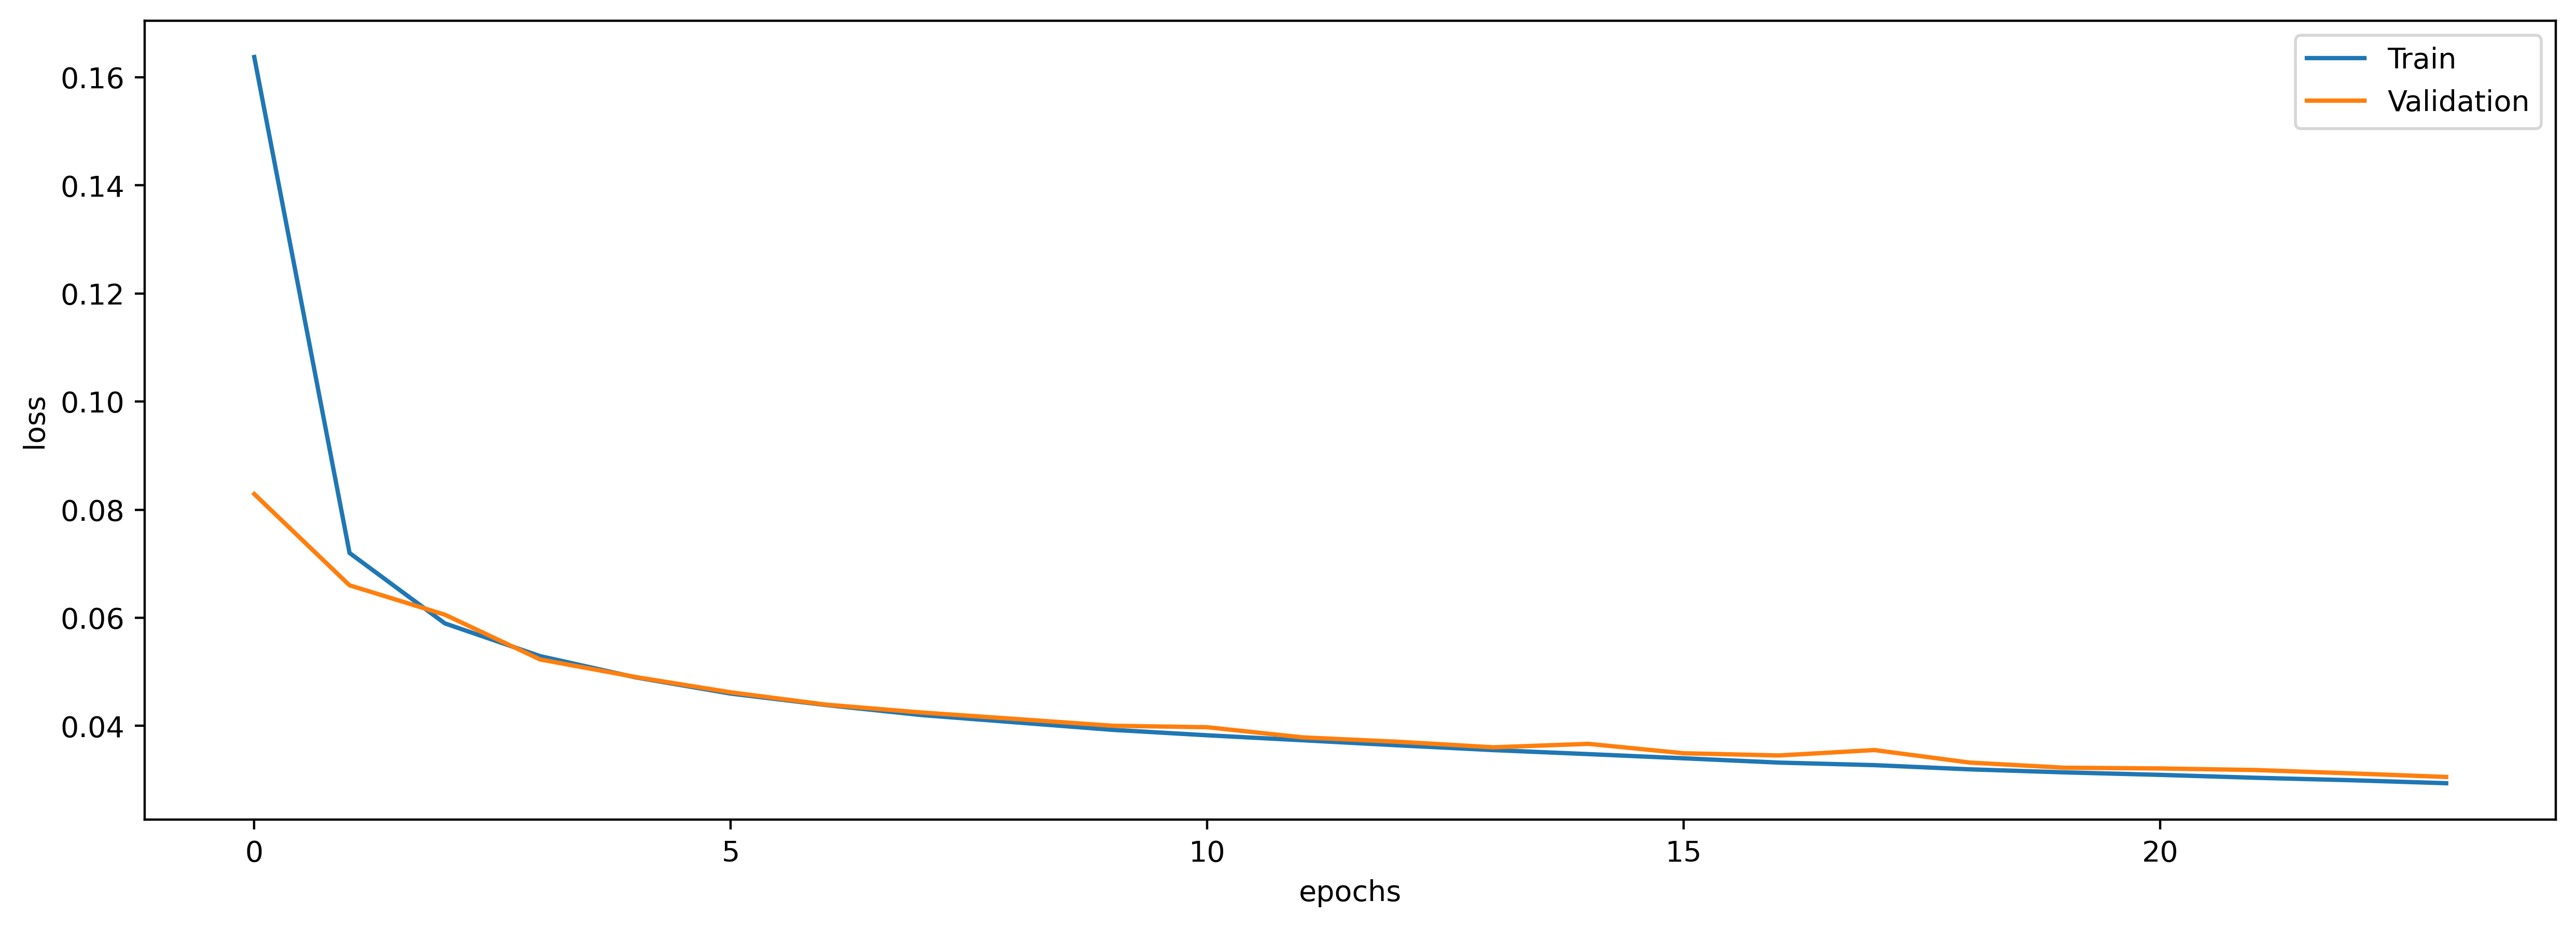

In [11]:
model.results.plot()

  0%|          | 0/1746 [00:00<?, ?it/s]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1746 samples in 0.001s...
[t-SNE] Computed neighbors for 1746 samples in 0.768s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1746
[t-SNE] Computed conditional probabilities for sample 1746 / 1746
[t-SNE] Mean sigma: 65.484107
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.657532
[t-SNE] KL divergence after 300 iterations: 1.274894
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1746 samples in 0.001s...
[t-SNE] Computed neighbors for 1746 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1746
[t-SNE] Computed conditional probabilities for sample 1746 / 1746
[t-SNE] Mean sigma: 18465.264990
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.391514
[t-SNE] KL divergence after 300 iterations: 1.219255
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1746 samples in 0.001s...
[t-SNE] Computed neighbors for 1746 sample

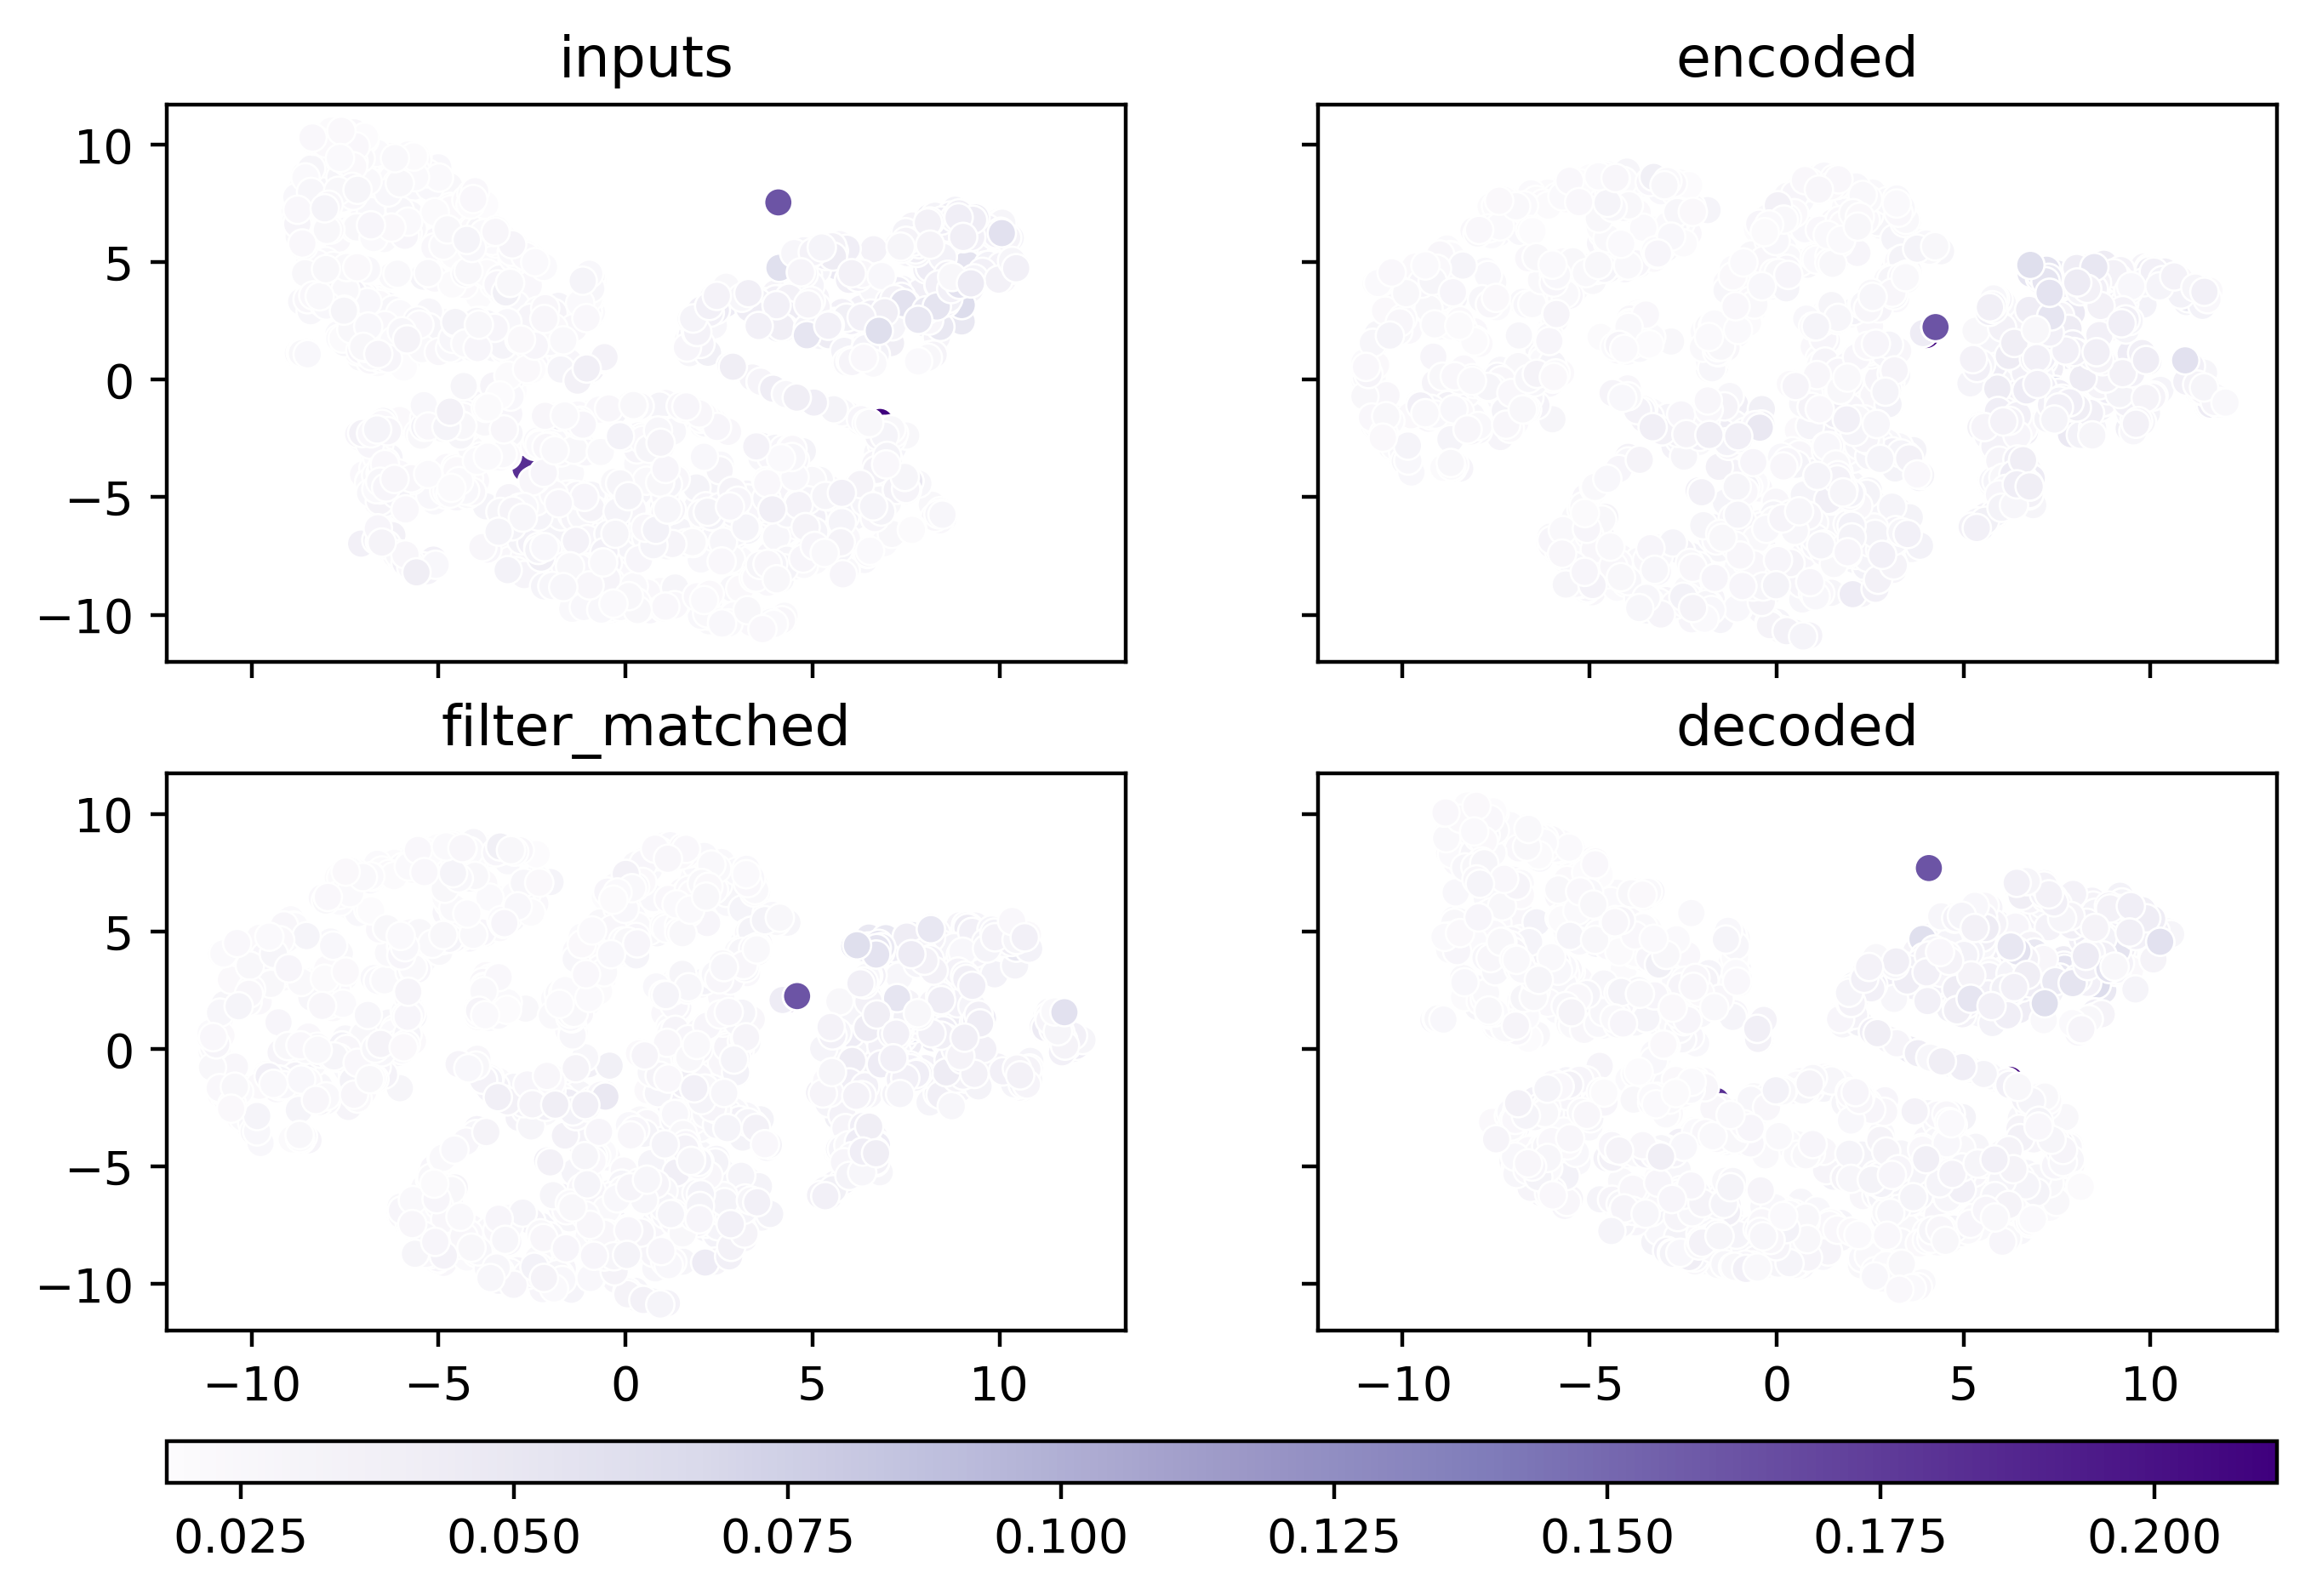

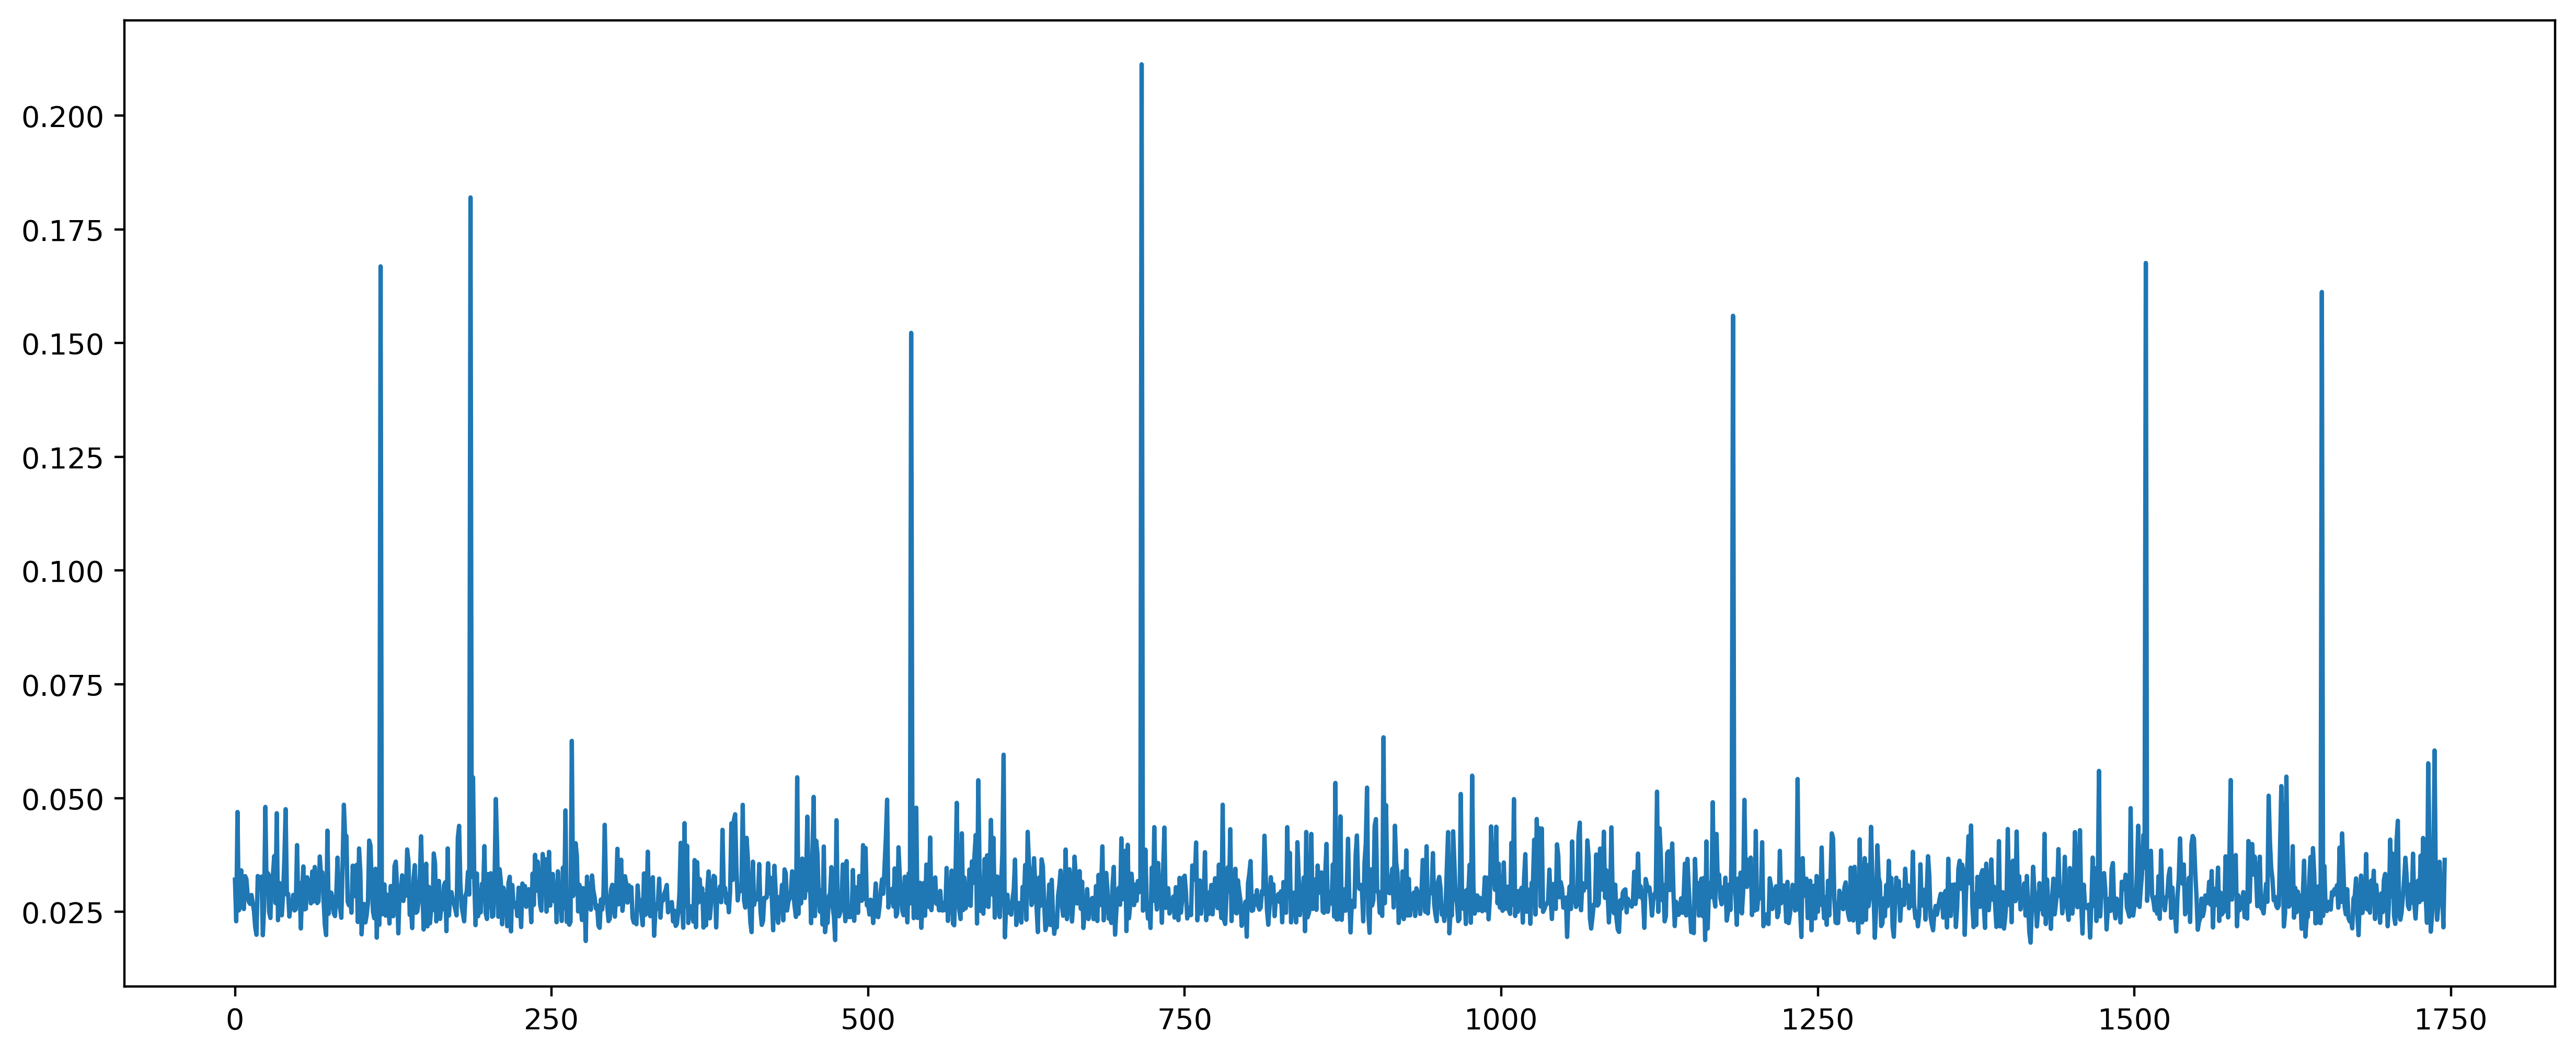

In [12]:
feature_vectors, loss = model.calc_feature_vectors(dataset=data["validation"], transform=transform["validation"])
model.plot_feature_vectors(feature_vectors=feature_vectors, loss=loss)

In [15]:
import numpy as np
idxs = np.argsort(loss)[::-1][:3]
idxs, np.sort(loss)[::-1][:3]

(array([ 738, 1133, 1679]), array([0.25548777, 0.21123995, 0.19278266]))

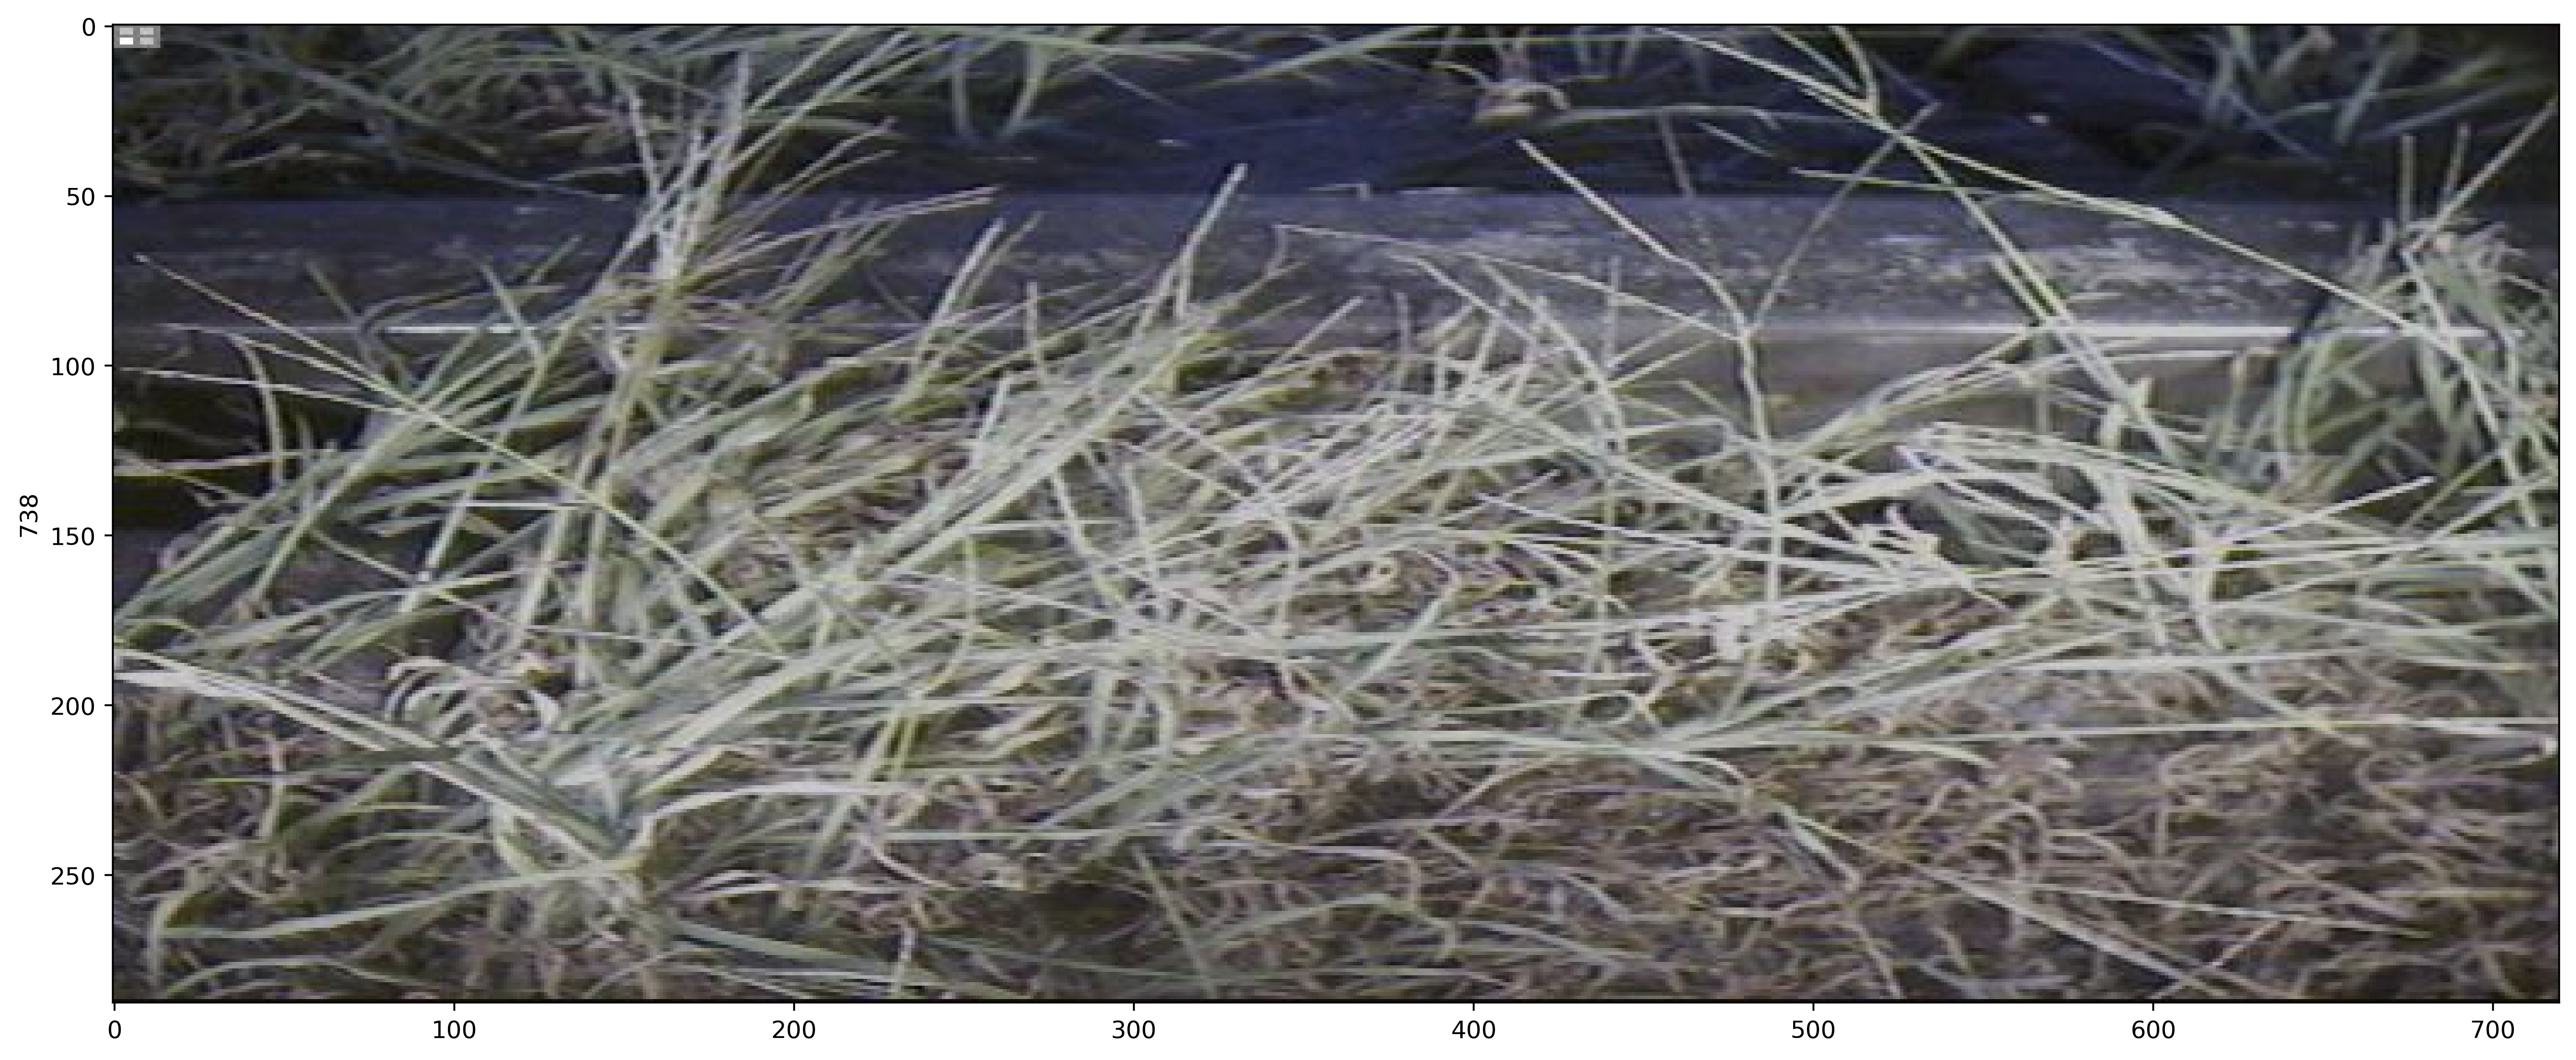

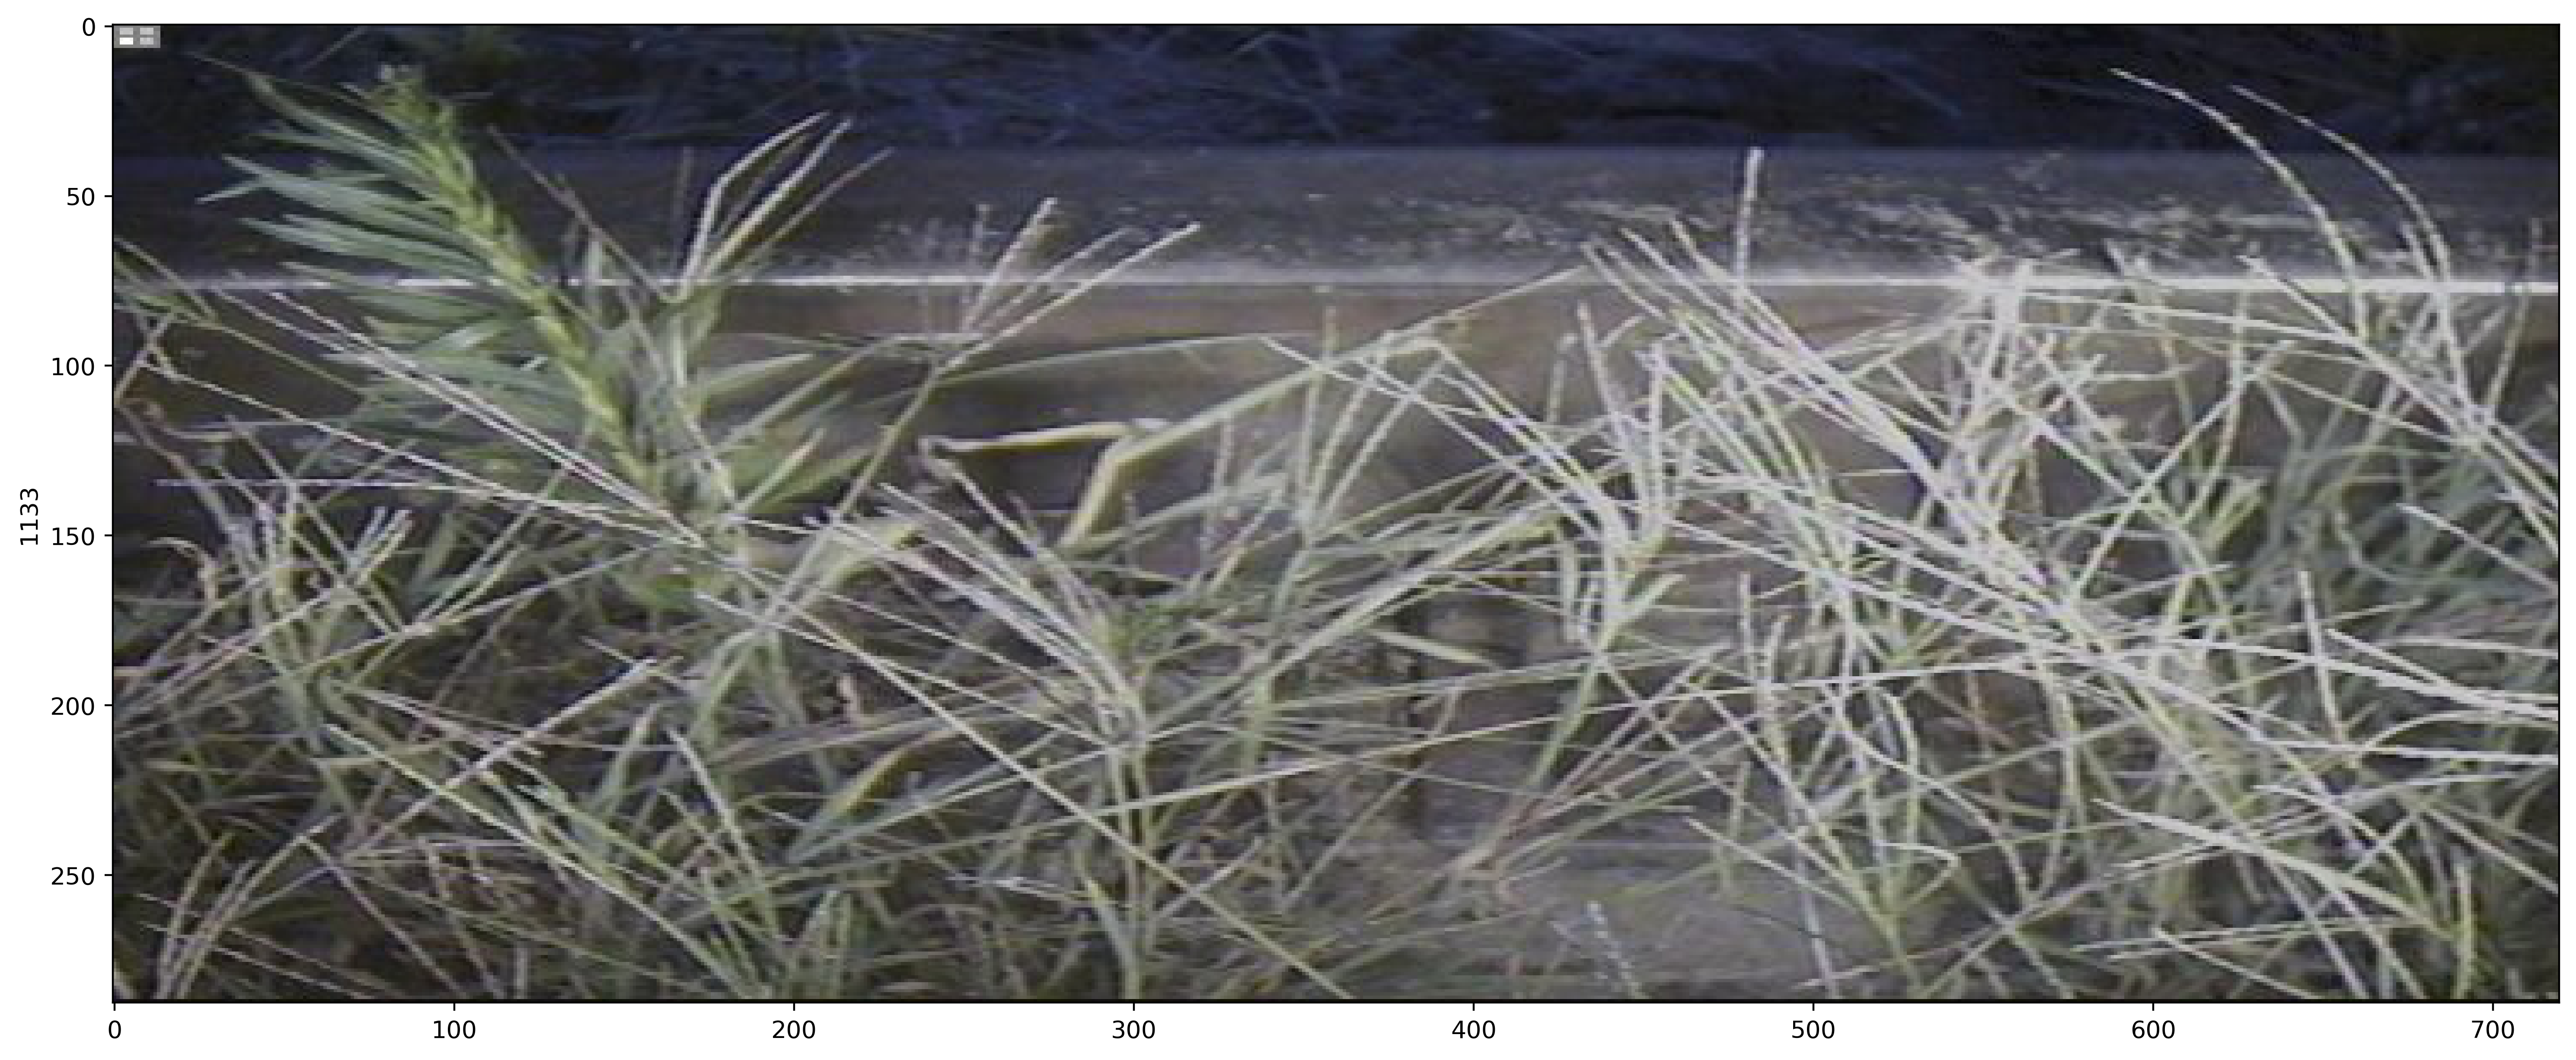

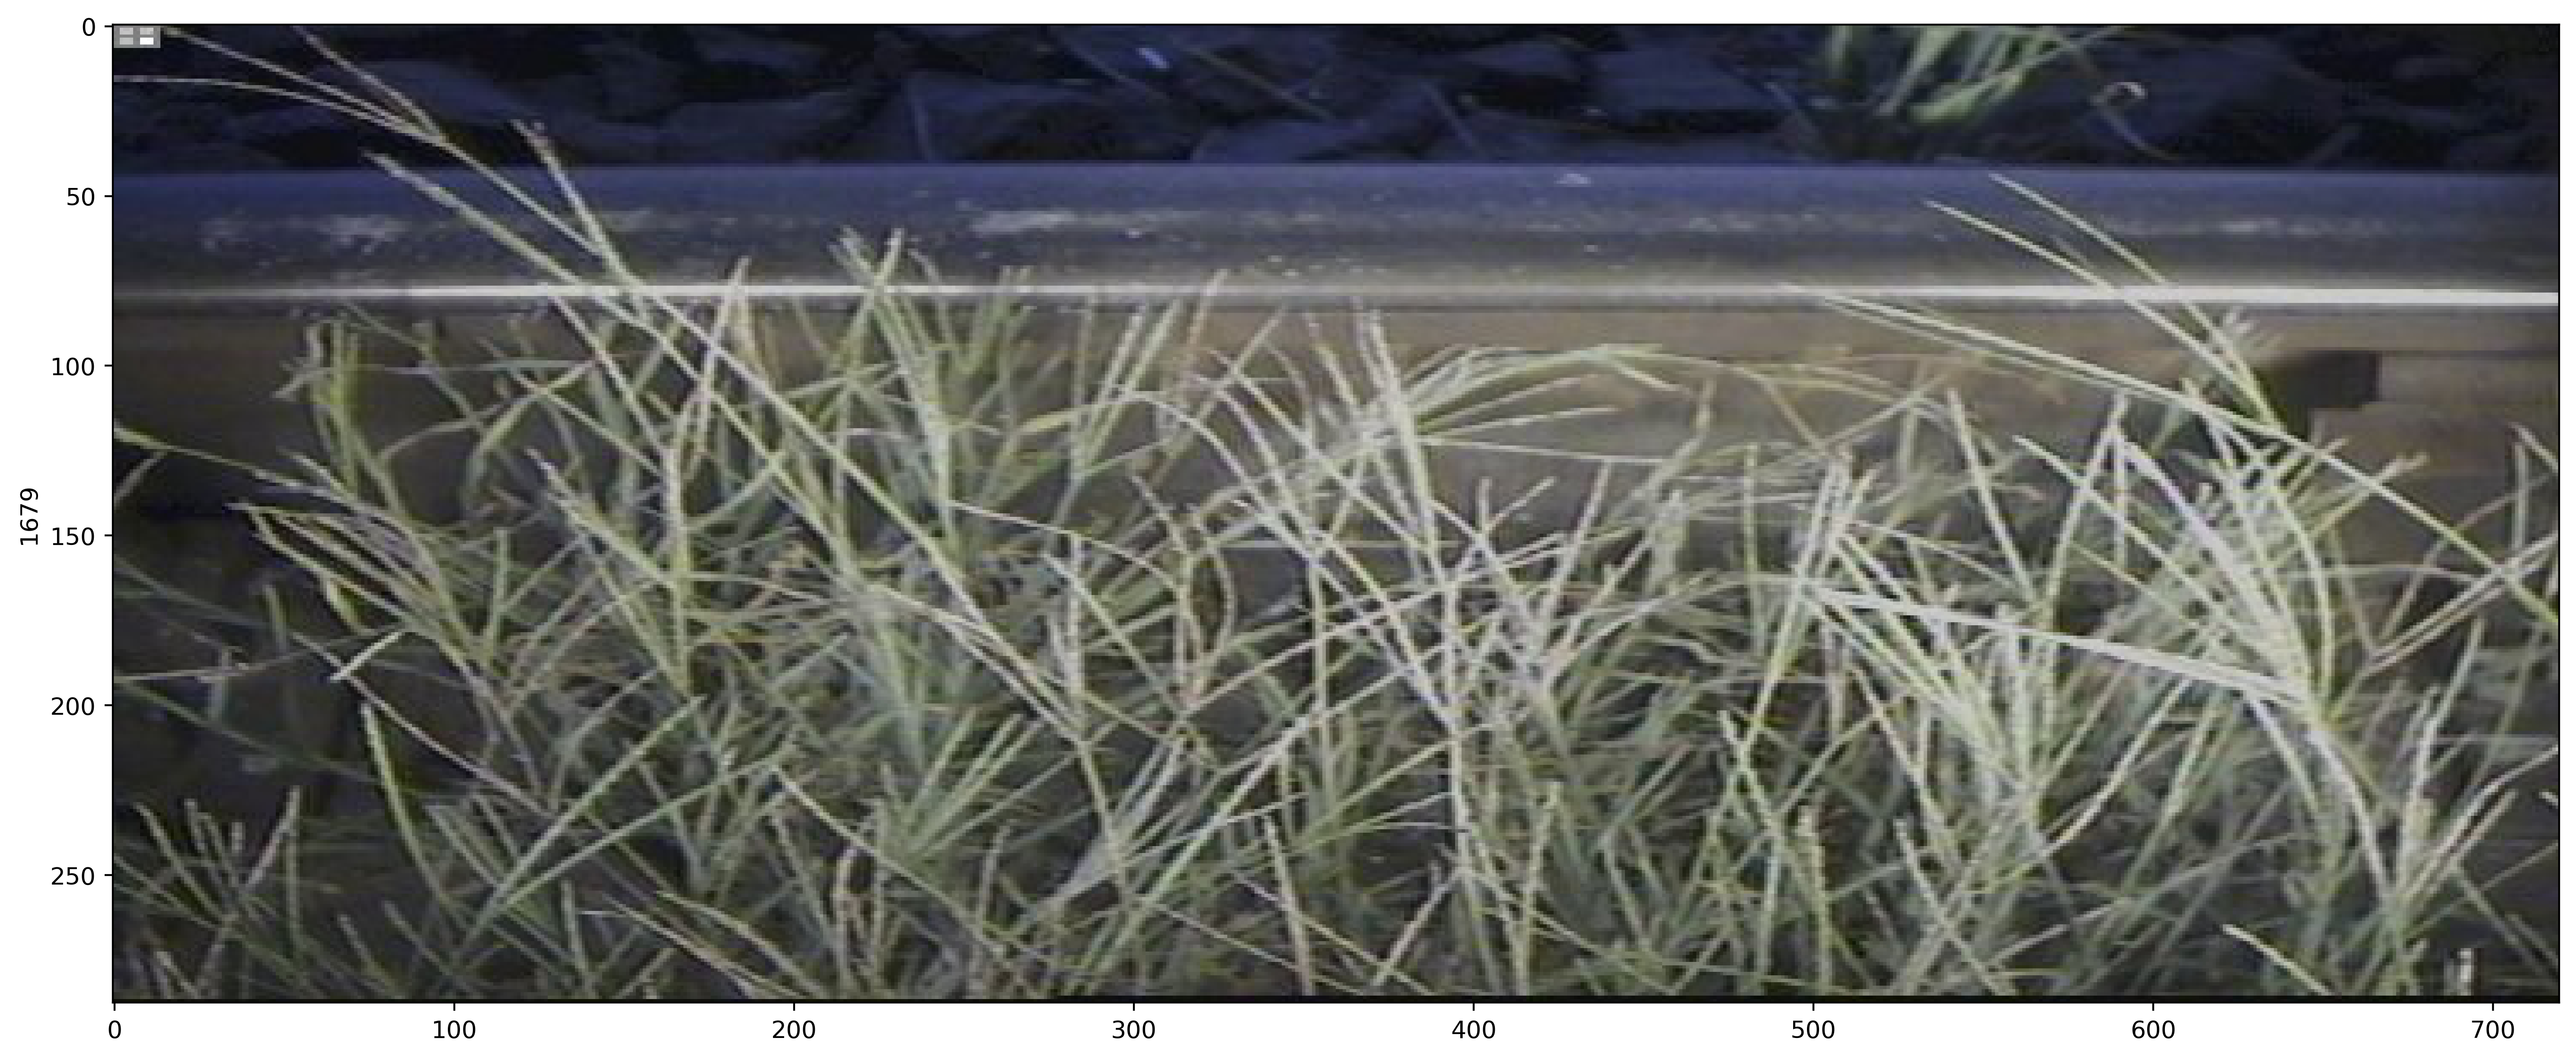

In [16]:
data["validation"].show_images(idxs=idxs)

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


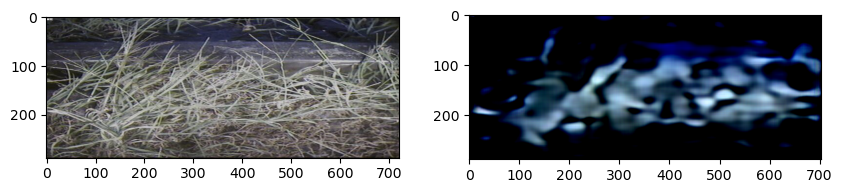

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


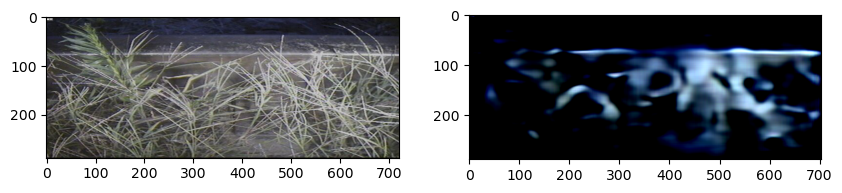

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


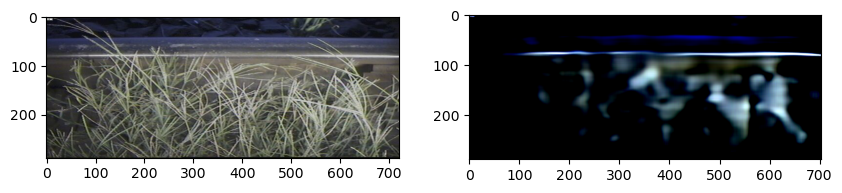

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


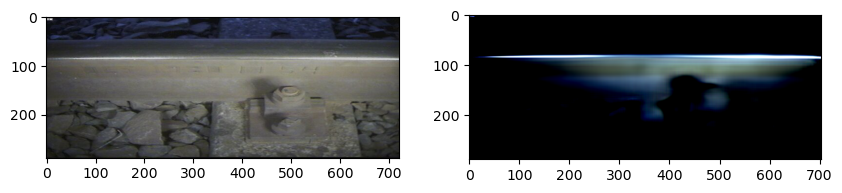

In [18]:
for idx in np.append(idxs, [0]):
    img = data["validation"].iloc[idx].img
    pred = model.predict(img, transform=transform["validation"])

    img = Image.open(img)

    _, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax[0].imshow(img)
    ax[1].imshow(pred.squeeze().permute(1, 2, 0).cpu().detach().numpy())
    plt.show()